In [1]:
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('Solarize_Light2')

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

import statsmodels.api as sm
from scipy.stats import boxcox, jarque_bera, probplot
from scipy.special import inv_boxcox
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

from datetime import timedelta
from math import sqrt
import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

import os
print(os.listdir("/Users/yc00027/Documents/air-quality-madrid/"))

import warnings
warnings.filterwarnings("ignore")

['.DS_Store', 'new_data', 'csvs_per_year', 'stations.csv', 'madrid.h5', '.ipynb_checkpoints']


# Air quality Madrid - Modelling

### Extracting the data

In [2]:
# Import full dataframe

df_full = pd.read_csv('full_madrid_air_quality.csv').set_index('date').sort_index()
df_full.index = pd.to_datetime(df_full.index)

# Select data for the time period, particles and stations of interest

first_date = '2012-01-01 00:00:00'
last_date = '2018-04-30 23:00:00'

particles_of_interest = ['NO_2', 'O_3', 'PM10', 'SO_2']

stations_of_interest = [28079004, 28079008, 28079011, 28079016, 28079017, 28079018, 
                        28079024, 28079035, 28079036, 28079038, 28079039, 28079040]

df_temp = df_full.loc[first_date:last_date][particles_of_interest + ['station']].sort_index()
df_temp = df_temp.loc[df_temp['station'].isin(stations_of_interest)]

print(f'The time period is from {first_date} to {last_date}')
print('')

# Generate dataframe for one particle and one station of interest

particle_of_interest = 'NO_2'
station_of_interest = 28079008

print(f'The particle of interest is: {particle_of_interest}')
print('')

print(f'The station of interest is: {station_of_interest}')
print('')

oneparticle_onestation = df_temp.loc[df_temp['station'] == station_of_interest]
oneparticle_onestation = oneparticle_onestation.drop(columns = [x for x in particles_of_interest if x is not particle_of_interest], axis=1)
oneparticle_onestation.drop('station', axis=1, inplace=True)

print(f'Missing values for particle and station of interest: {round(oneparticle_onestation[particle_of_interest].isnull().mean()*100, 2)}%')
print('')
oneparticle_onestation.dropna(inplace=True)

oneparticle_onestation['diff_particle'] = oneparticle_onestation[particle_of_interest].diff()
oneparticle_onestation['bc_particle'], lamb = boxcox(oneparticle_onestation[particle_of_interest])
oneparticle_onestation['bc_diff_particle'] = oneparticle_onestation['bc_particle'].diff()
oneparticle_onestation.fillna(0, inplace=True)

oneparticle_onestation['quarter'] = oneparticle_onestation.index.quarter
oneparticle_onestation['dayofyear'] = oneparticle_onestation.index.dayofyear
oneparticle_onestation['dayofmonth'] = oneparticle_onestation.index.day
oneparticle_onestation['weekyear'] = oneparticle_onestation.index.weekofyear
oneparticle_onestation['weekday'] = oneparticle_onestation.index.weekday
oneparticle_onestation['hour'] = oneparticle_onestation.index.hour
oneparticle_onestation['year'] = oneparticle_onestation.index.year
oneparticle_onestation['month'] = oneparticle_onestation.index.month
oneparticle_onestation.fillna(0, inplace=True)

print(f'One particle, one station DF shape: {oneparticle_onestation.shape}')
oneparticle_onestation.head()

The time period is from 2012-01-01 00:00:00 to 2018-04-30 23:00:00

The particle of interest is: NO_2

The station of interest is: 28079008

Missing values for particle and station of interest: 1.17%

One particle, one station DF shape: (54841, 12)


,NO_2,diff_particle,bc_particle,bc_diff_particle,quarter,dayofyear,dayofmonth,weekyear,weekday,hour,year,month
date,,,,,,,,,,,,
2012-01-01 00:00:00,97.0,0.0,7.645953,0.000000,1,1,1,52,6,0,2012,1
2012-01-01 01:00:00,114.0,17.0,8.071571,0.425619,1,1,1,52,6,1,2012,1
2012-01-01 02:00:00,120.0,6.0,8.209782,0.138211,1,1,1,52,6,2,2012,1
2012-01-01 03:00:00,106.0,-14.0,7.878034,-0.331748,1,1,1,52,6,3,2012,1
2012-01-01 04:00:00,71.0,-35.0,6.863006,-1.015028,1,1,1,52,6,4,2012,1


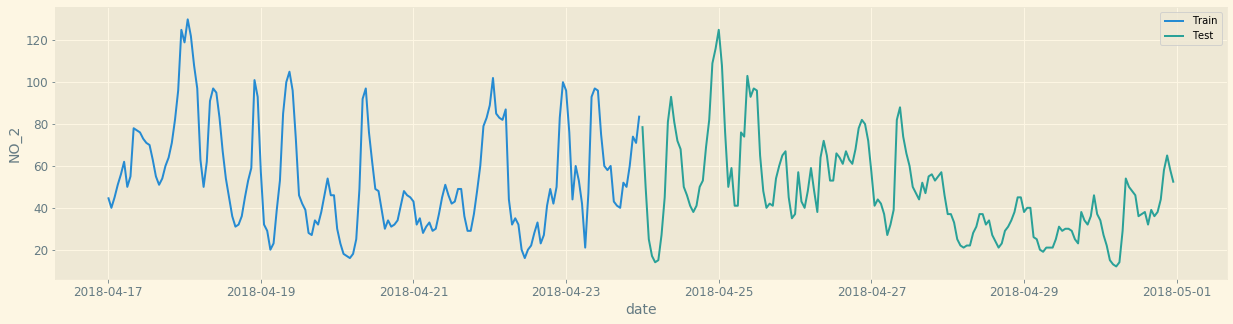

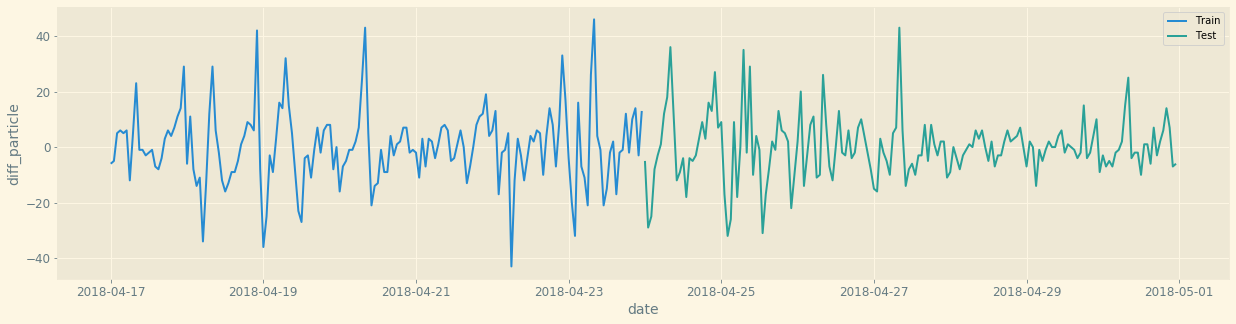

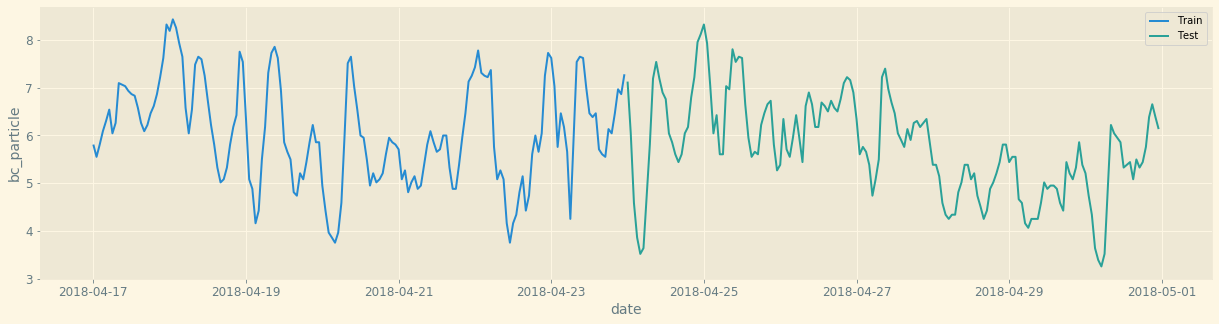

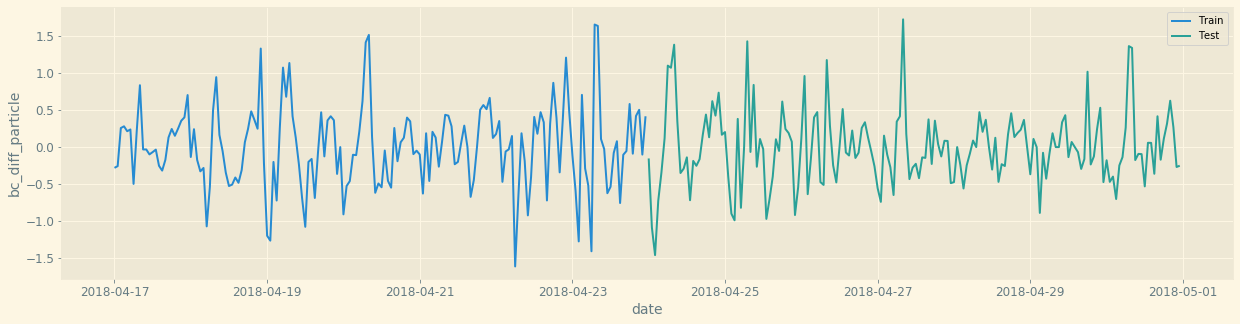

Train shape: (54673, 12)
Test shape: (168, 12)
Test proportion (percent): 0.31


In [3]:
# Define train, test split 

num_weeks = 1
test_size = 24 * 7 * num_weeks 
train_size = len(oneparticle_onestation[particle_of_interest])-(test_size)
train, test = oneparticle_onestation[:train_size], oneparticle_onestation[train_size:]
    
fig, ax = plt.subplots(figsize=(21,5))
sns.lineplot(x = train[particle_of_interest].iloc[-test_size:].index, y = train[particle_of_interest].iloc[-test_size:], label='Train')
sns.lineplot(x = test[particle_of_interest].index, y = test[particle_of_interest], label='Test')
plt.legend(loc='best')
plt.show()

fig, ax = plt.subplots(figsize=(21,5))
sns.lineplot(x = train['diff_particle'].iloc[-test_size:].index, y = train['diff_particle'].iloc[-test_size:], label='Train')
sns.lineplot(x = test['diff_particle'].index, y = test['diff_particle'], label='Test')
plt.legend(loc='best')
plt.show()

fig, ax = plt.subplots(figsize=(21,5))
sns.lineplot(x = train['bc_particle'].iloc[-test_size:].index, y = train['bc_particle'].iloc[-test_size:], label='Train')
sns.lineplot(x = test['bc_particle'].index, y = test['bc_particle'], label='Test')
plt.legend(loc='best')
plt.show()

fig, ax = plt.subplots(figsize=(21,5))
sns.lineplot(x = train['bc_diff_particle'].iloc[-test_size:].index, y = train['bc_diff_particle'].iloc[-test_size:], label='Train')
sns.lineplot(x = test['bc_diff_particle'].index, y = test['bc_diff_particle'], label='Test')
plt.legend(loc='best')
plt.show()
    
print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')
print('Test proportion (percent): %.2f' % (len(test) / len(oneparticle_onestation) * 100))

In [4]:
# Define ARIMA modelling function

def predict_ARIMA(train, test, target, pdq):
    model_name = f'ARIMA, order={str(pdq)}, target: {target}'
    test_len = len(test)
    model = ARIMA(train[target], order=pdq)
    model_fit = model.fit(transparams=False, disp=-1)
    predictions = model_fit.forecast(test_len)
    predictions = pd.Series(predictions[0], index = test.index)
    aic = model_fit.aic
    print(model_name)
    print(f'AIC: {aic}')
    return model_name, predictions, model_fit

# Define SARIMA modelling function

def predict_SARIMA(train, test, target, pdq, pdqs):
    model_name = f'SARIMA, order={str(pdq)}, seasonal_order={str(pdqs)}, target: {target}'
    test_len = len(test)
    model = SARIMAX(train[target], order=pdq, seasonal_order=pdqs, enforce_stationarity=False, enforce_invertibility=False) 
    model_fit = model.fit(disp=-1)
    predictions = model_fit.forecast(test_len)
    predictions = pd.Series(predictions[0], index = test.index)
    aic = model_fit.aic
    print(model_name)
    print(f'AIC: {aic}')
    return model_name, predictions, model_fit

# Define function to revert transformations

def revert_predictions(train, predictions):
    predictions_cumsum = predictions.cumsum()
    predictions_inv_bc = inv_boxcox(predictions_cumsum, lamb)
    predictions_final = train[particle_of_interest][-1] + predictions_inv_bc
    return predictions_final

# Define function to plot actuals vs predictions

def plot_actuals_predictions(predictions_final):
    fig, ax = plt.subplots(figsize=(21,7))
    actuals = plt.plot(test[particle_of_interest], label='Actuals')
    predictions = plt.plot(predictions_final, label='Predictions')
    error = np.sqrt(mean_squared_error(test[particle_of_interest], predictions_final))
    plt.legend(loc='best')
    plt.title('RMSE: %.2f'% error)
    plt.show()
    
# Define model evaluation function

def evaluate_forecast(predictions_final, model_name):
    results = pd.DataFrame({'models': model_name,
                           }, index=[0])
    results['r2_score'] = r2_score(test[particle_of_interest], predictions_final)
    results['mean_abs_error'] = mean_absolute_error(test[particle_of_interest], predictions_final)
    results['median_abs_error'] = median_absolute_error(test[particle_of_interest], predictions_final)
    results['mse'] = mean_squared_error(test[particle_of_interest], predictions_final)
    results['rmse'] = np.sqrt(results['mse'])
    return results

# Define function to run ARIMA model and get results

def run_ARIMA(params, target):
    model = predict_ARIMA(train, test, target, params)
    if target=='bc_diff_particle':
        predictions_final = revert_predictions(train, model[1])
    else:
        predictions_final = inv_boxcox(model[1], lamb)
    plot_actuals_predictions(predictions_final)
    results = evaluate_forecast(predictions_final, model[0])
    return results

# Define function to run SARIMA model and get results

def run_SARIMA(params, seasonal_params, target):
    model = predict_SARIMA(train, test, target, params, seasonal_params)
    if target=='bc_diff_particle':
        predictions_final = revert_predictions(train, model[1])
    else:
        predictions_final = inv_boxcox(model[1], lamb)
    plot_actuals_predictions(predictions_final)
    results = evaluate_forecast(predictions_final, model[0])
    return results

# Define model validation function

def model_diagnostics(residuals, model_fit):
    godfrey = acorr_breusch_godfrey(model_fit, nlags= 40)
    j_bera = jarque_bera(residuals)

    print('Results of Breusch-Godfrey:')
    print('Null Hypothesis: No auotcorrelation')
    print('P-Value =< Alpha(.05) => Reject Null')   
    print(f'p-values: {godfrey[1]}\n')
    print('Results of Jarque-Bera:')
    print('Null Hypothesis: Data is normally distributed')
    print('P-Value =< Alpha(.05) => Reject Null')   
    print(f'p-value: {j_bera[1]}')
    
# Define plot diagnostics function

def plot_diagnostics(residuals):
    residuals.plot(title='ARIMA Residuals', figsize=(15, 10))
    plt.show()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    ax[0].set_title('ARIMA Residuals KDE')
    ax[1].set_title('ARIMA Resduals Probability Plot')    
    residuals.plot(kind='kde', ax=ax[0])
    probplot(residuals, dist='norm', plot=ax[1])
    plt.show() 

# Time Series forecasting

Among the different types of TS models that exist, the following ones are the most commonly used: 

0. Basic Models

1. Autoregression (AR)

2. Moving Average 

3. Autoregressive Moving Average (ARMA)

4. Autoregressive Integrated Moving Average (ARIMA)

5. Seasonal Autoregressive Integrated Moving-Average (SARIMA)

### 0. Basic models

In [5]:
# Define functions for basic models

def predict_previous_value(data, target_name):
    data = data.sort_index()
    predictions = data[target_name].shift(1).fillna(0)
    return predictions

def predict_previous_day_value(data, target_name):
    data = data.sort_index()
    predictions = data.groupby('hour')[target_name].shift(1).fillna(0)
    return predictions

def predict_previous_week_value(data, target_name):
    data = data.sort_index()
    predictions = data.groupby(['hour', 'weekday'])[target_name].shift(1).fillna(0)
    return predictions

def predict_rolling_average(data, target_name):
    data = data.sort_index()
    predictions = data.shift(1).rolling(window=2, min_periods=1)[target_name].mean().fillna(0)
    return predictions

def predict_exponential_rolling_average(data, target_name):
    data = data.sort_index()
    predictions = data.shift(1).ewm(min_periods=1, halflife=1)[target_name].mean().fillna(0)
    return predictions

In [6]:
# Define function to output results for all models

def BasicModels(data, particle_of_interest, models):

    results = pd.DataFrame()
    names = []
    
    for name, model in models:
        
        predictions = model(data, particle_of_interest)
        names.append(name)
        results = results.append(evaluate_forecast(predictions[train_size:], name))   
    return results
    
def PlotBasicModels(data, particle_of_interest, models):
    
    for name, model in models:
        
        predictions = model(data, particle_of_interest)[train_size:]
        predictions_and_target = pd.merge(pd.DataFrame(data[particle_of_interest]), predictions.rename('predictions'), \
                                 left_index=True, right_index=True)
    
        fig, ax = plt.subplots(figsize=(21, 7))
        ax.plot(predictions_and_target['predictions'], label='prediction')
        ax.plot(data[particle_of_interest][train_size:], label='target')
        ax.axes.set_xlim(data[train_size:].index.min(), data[train_size:].index.max())
        ax.set_title(f'Predictions for {name}')
        plt.legend()

In [7]:
models = [
    ('previous hour', predict_previous_value),
    ('same hour, previous day', predict_previous_day_value),
    ('same hour, previous week', predict_previous_week_value),
    ('rolling average', predict_rolling_average),
    ('exponential rolling average', predict_exponential_rolling_average)
]

basic_models_results = BasicModels(oneparticle_onestation, particle_of_interest, models)
basic_models_results

,models,r2_score,mean_abs_error,median_abs_error,mse,rmse
0,previous hour,0.746614,7.773810,5.500000,123.452381,11.110913
0,"same hour, previous day",-0.073556,16.880952,13.000000,523.047619,22.870234
0,"same hour, previous week",-0.285305,19.583333,14.000000,626.214286,25.024274
0,rolling average,0.606051,9.854167,6.500000,191.936012,13.854097
0,exponential rolling average,0.584022,10.318985,7.176439,202.668927,14.236184


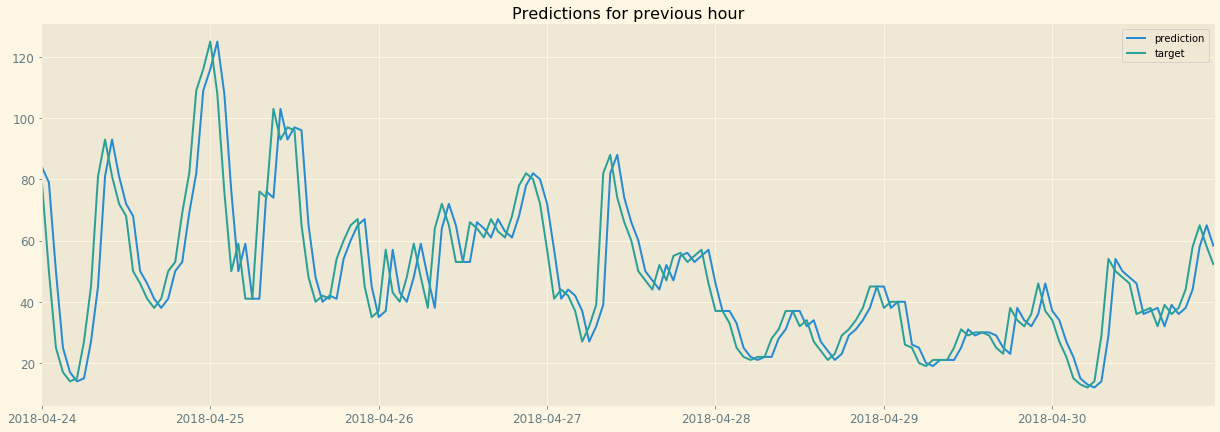

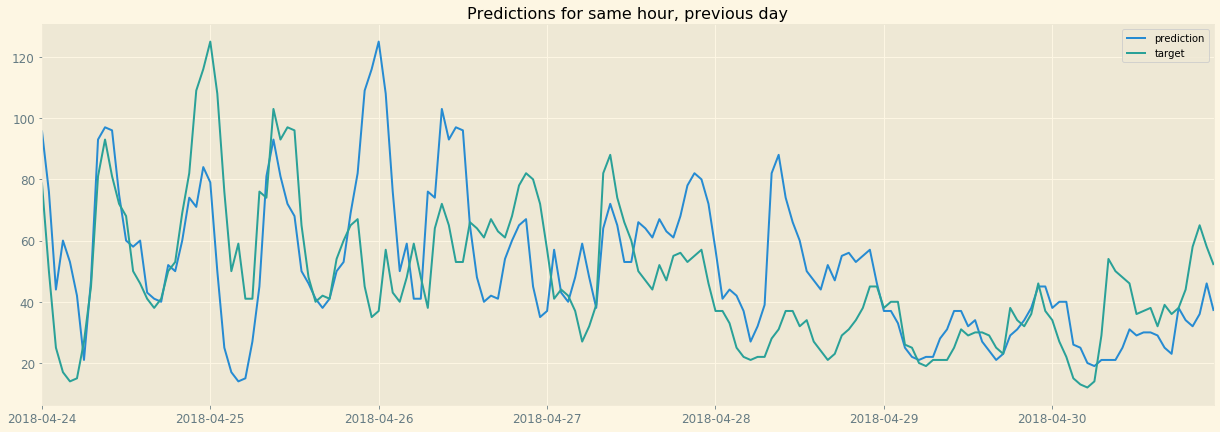

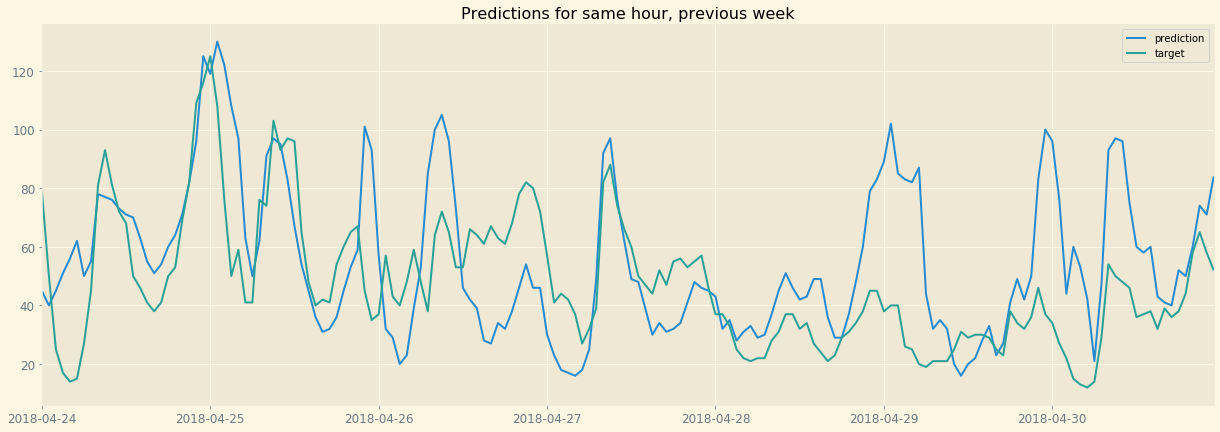

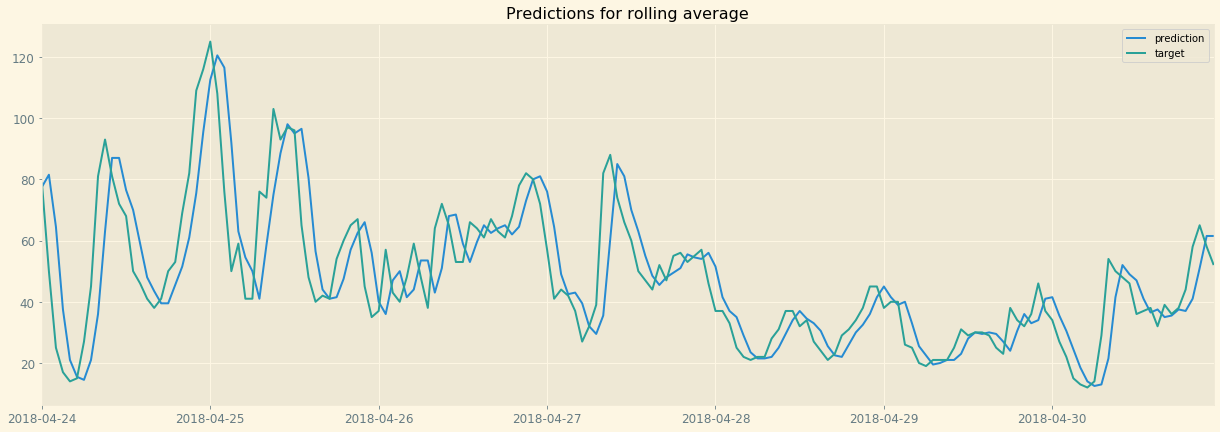

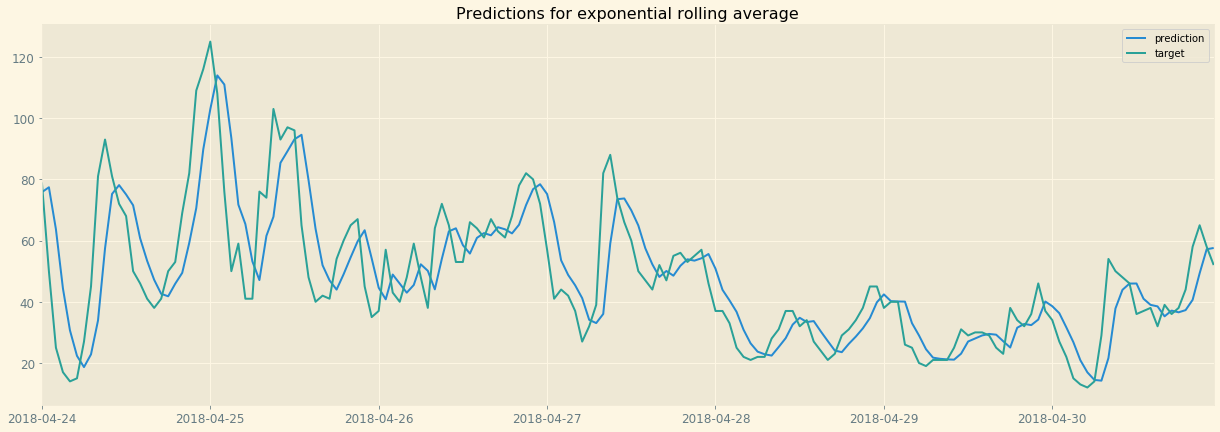

In [8]:
PlotBasicModels(oneparticle_onestation, particle_of_interest, models)

## 1. Autoregression (AR)

The autoregression (AR) method models the next step in the sequence as a linear function of the observations at prior time steps.

`Autoregressive` models are based on the idea that current value of the series, Xt, can be explained as a linear combination of n past values

Xt−1, Xt−2, . . . , Xt−p, together with a random error in the same series


- __Number of AR (Auto-Regressive) terms (p):__ p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

ARIMA, order=(5, 0, 0), target: bc_particle
AIC: 77531.2168617429


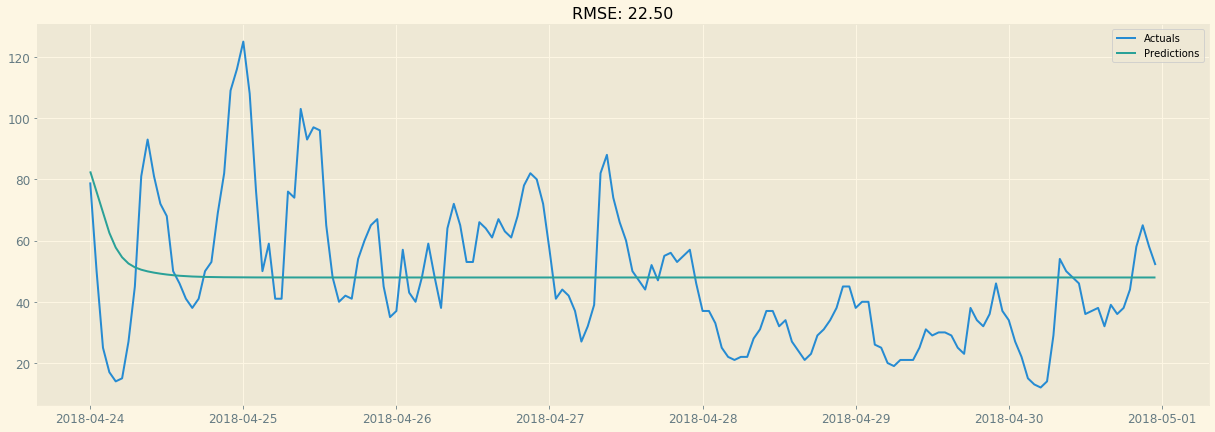

In [9]:
results = run_ARIMA((5,0,0), 'bc_particle')

ARIMA, order=(5, 1, 0), target: bc_particle
AIC: 80592.65151796538


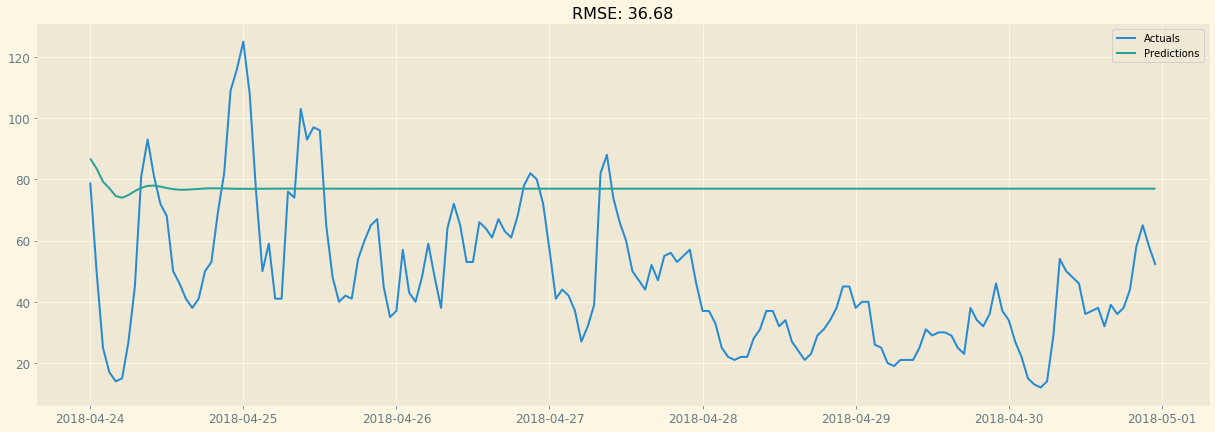

In [10]:
results = results.append(run_ARIMA((5,1,0), 'bc_particle'))

ARIMA, order=(5, 0, 0), target: bc_diff_particle
AIC: 80593.45749006524


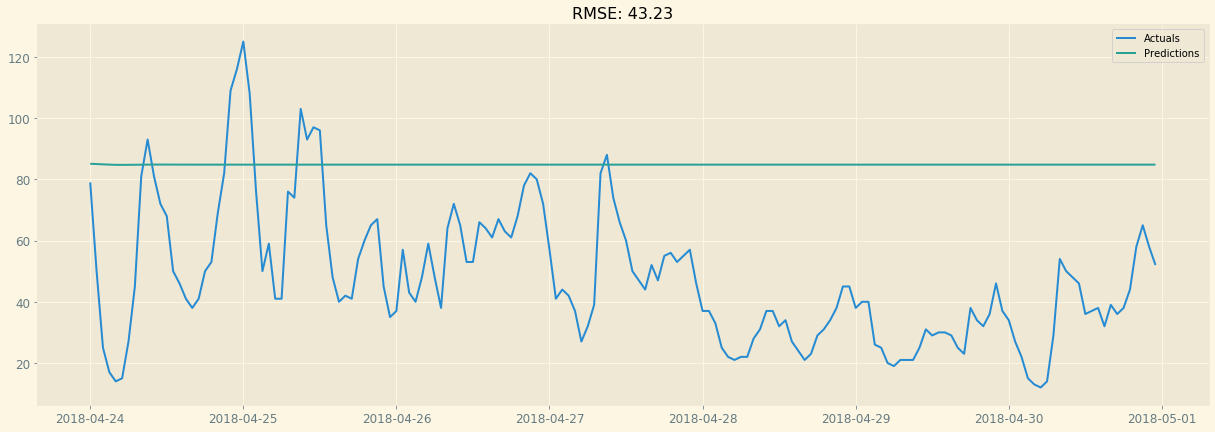

In [11]:
results = results.append(run_ARIMA((5,0,0), 'bc_diff_particle'))

## 2. Moving Average (MA)

The moving average model is probably the most naive approach to time series modelling. This model simply states that the next observation is the mean of all past observations.


- __Number of MA (Moving Average) terms (q):__ q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value. 

ARIMA, order=(0, 1, 5), target: bc_particle
AIC: 78414.30179740123


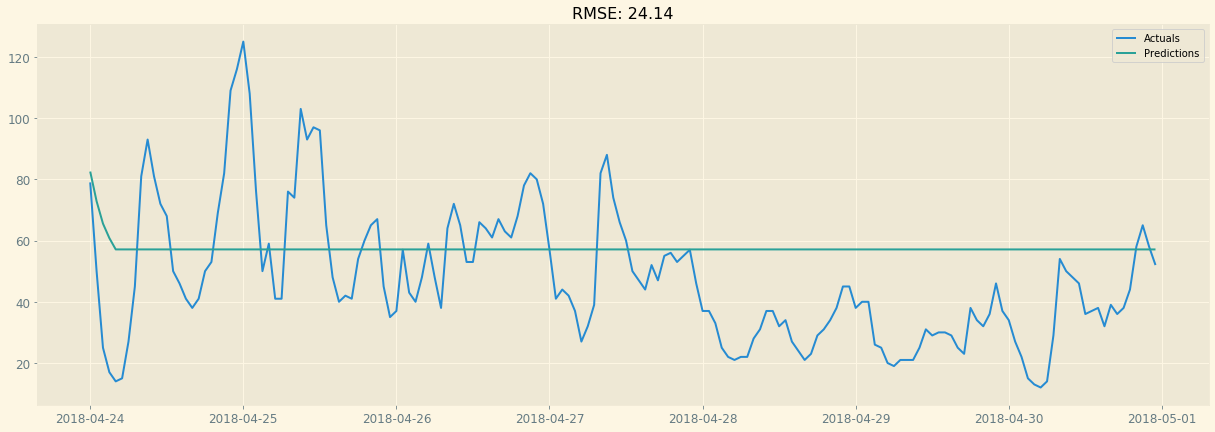

In [12]:
results = results.append(run_ARIMA((0,1,5), 'bc_particle'))

ARIMA, order=(0, 0, 5), target: bc_diff_particle
AIC: 78416.04983968464


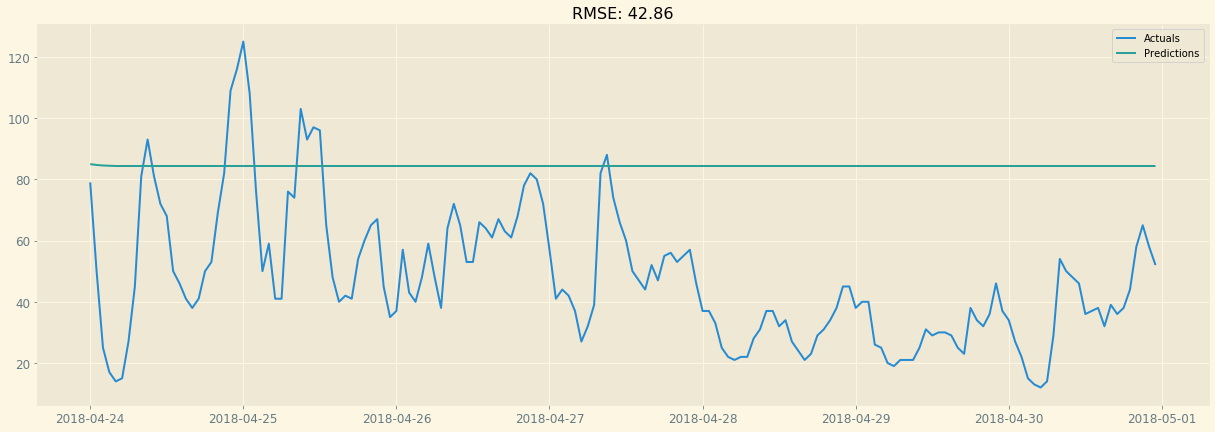

In [13]:
results = results.append(run_ARIMA((0,0,5), 'bc_diff_particle'))

## 3. Autoregressive Moving Average (ARMA)

`Autoregressive–moving-average (ARMA)` models provide a parsimonious description of a stationary  process in terms of two polynomials, one for the **autoregression (AR)** and the second for the **moving average (MA).** 

- __Number of AR (Auto-Regressive) terms (p):__ p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

- __Number of MA (Moving Average) terms (q):__ q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value. 


ARIMA, order=(5, 0, 5), target: bc_particle
AIC: 77168.51345193715


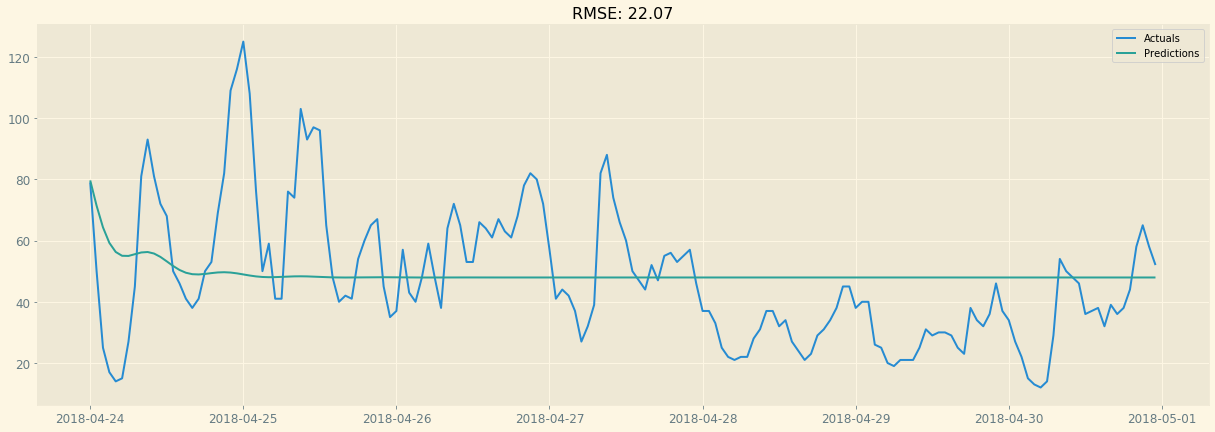

In [14]:
results = results.append(run_ARIMA((5,0,5), 'bc_particle'))

ARIMA, order=(5, 0, 5), target: bc_diff_particle
AIC: 79065.59010736676


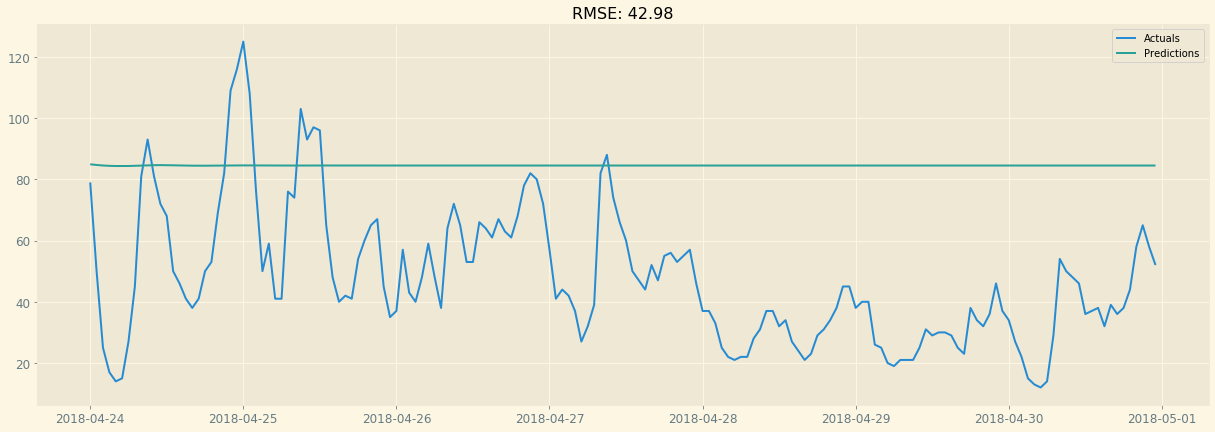

In [15]:
results = results.append(run_ARIMA((5,0,5), 'bc_diff_particle'))

## 4. Autoregressive Integrated Moving Average (ARIMA)

It is similiar to ARMA but with some differences. The only difference, then, is the “integrated” part. Integrated refers to the number of times needed to difference a series in order to achieve stationarity, which is required for ARMA models to be valid. By differencing, I mean forming a new series by subtracting observation 1 from 2, 2, from 3, etc.

So an `ARMA` model is equivalent to an `ARIMA` model of the same MA and AR orders with no differencing.

The typical short-hand notation for ARMA is “ARMA(p,q)” where p is the AR order and q is the MA order. For ARIMA, the notation is “ARIMA(p,d,q)” where the added d is the order of integration, or number of differences. So the following two statements sum it all up:

> ARMA(p,q) is equivalent to ARIMA(p,0,q)

Given an ARIMA(p,d,q), if d>0 one can modle this as an ARMA by running an ARMA(p,q) after differencing the original series d times: 

- __Number of AR (Auto-Regressive) terms (p):__ p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
- __Number of Differences (d):__ d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series.
- __Number of MA (Moving Average) terms (q):__ q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value. 

<br>__Observations from EDA on the time series:__
- Non stationarity implies at least one level of differencing (d) is required in ARIMA
- [The next step is to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively, using PACF, ACF plots](https://people.duke.edu/~rnau/411arim3.htm)

[Tuning ARIMA parameters](https://machinelearningmastery.com/tune-arima-parameters-python/)


> Note: A problem with ARIMA is that it does not support seasonal data. That is a time series with a repeating cycle. ARIMA expects data that is either not seasonal or has the seasonal component removed, e.g. seasonally adjusted via methods such as seasonal differencing.

ARIMA, order=(5, 1, 5), target: bc_particle
AIC: 79066.14822097342


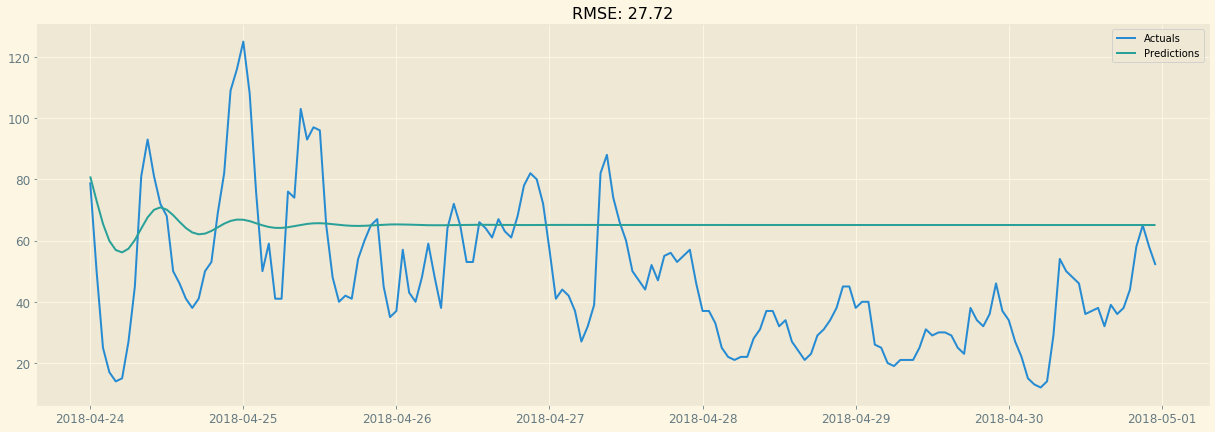

In [16]:
results = results.append(run_ARIMA((5,1,5), 'bc_particle'))

In [17]:
results

,models,r2_score,mean_abs_error,median_abs_error,mse,rmse
0,"ARIMA, order=(5, 0, 0), target: bc_particle",-0.039023,17.699984,15.000000,506.222909,22.499398
0,"ARIMA, order=(5, 1, 0), target: bc_particle",-1.761423,32.776925,34.945345,1345.394317,36.679617
0,"ARIMA, order=(5, 0, 0), target: bc_diff_particle",-2.836248,39.318706,41.298895,1869.060587,43.232633
0,"ARIMA, order=(0, 1, 5), target: bc_particle",-0.195759,20.287273,19.104218,582.586512,24.136829
0,"ARIMA, order=(0, 0, 5), target: bc_diff_particle",-2.769662,38.932398,40.999978,1836.619312,42.855797
0,"ARIMA, order=(5, 0, 5), target: bc_particle",0.000398,17.431171,14.866814,487.016664,22.068454
0,"ARIMA, order=(5, 0, 5), target: bc_diff_particle",-2.791674,39.062975,41.013558,1847.343691,42.980736
0,"ARIMA, order=(5, 1, 5), target: bc_particle",-0.577475,23.931885,24.383602,768.562443,27.722959
